<a href="https://colab.research.google.com/github/gs1charancharan/masai/blob/main/Copy_of_Healthcare_Diabetes_EDA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [ ]:
#Data Quality Check
#missing values, duplicates

print(f"Missing Values:, {df.isnull().sum()}")
print(f"Duplicate Rows:, {df.duplicated().sum()}")
print(f"Target Distribution:{df['diabetes'].value_counts()}")
print(f"\nTarget Balance: {(df['diabetes'].value_counts(normalize=True) * 100).round(2).to_dict()}")

Missing Values:, gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Duplicate Rows:, 3854
Target Distribution:diabetes
0    91500
1     8500
Name: count, dtype: int64

Target Balance: {0: 91.5, 1: 8.5}


In [ ]:
#staistical Summary

df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
df['gender'].unique()
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [ ]:
print("="*60 + "\n Feature Cardinality Test Beings : \n" + "="*60)

for column in df.columns:
  num_distinct = len(df[column].unique())
  feature_type = "Categorical" if num_distinct < 10 else " Numerical"
  print(f"{column:20s} | {num_distinct:6,} unique values | {feature_type}")

 Feature Cardinality Test Beings : 
gender               |      3 unique values | Categorical
age                  |    102 unique values |  Numerical
hypertension         |      2 unique values | Categorical
heart_disease        |      2 unique values | Categorical
smoking_history      |      6 unique values | Categorical
bmi                  |  4,247 unique values |  Numerical
HbA1c_level          |     18 unique values |  Numerical
blood_glucose_level  |     18 unique values |  Numerical
diabetes             |      2 unique values | Categorical


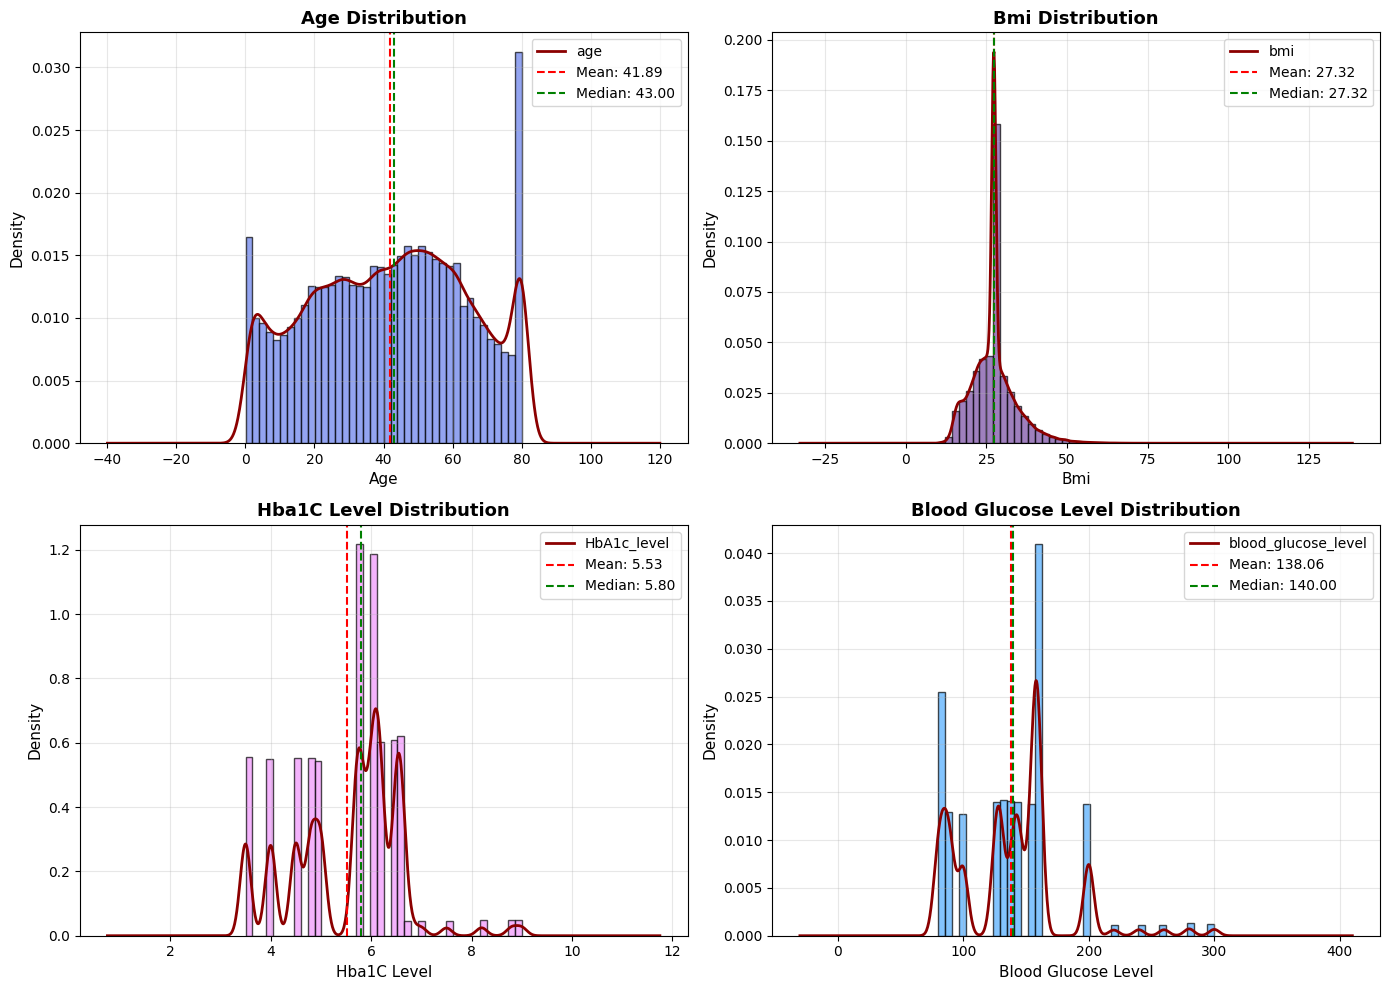

In [ ]:
#univariate Analysis

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
colors = ['#667eea', '#764ba2', '#f093fb', '#4facfe']

for idx, (feature, color) in enumerate(zip(numeric_features, colors)):
    ax = axes[idx // 2, idx % 2]

    # Histogram with KDE
    ax.hist(df[feature], bins=40, color=color, alpha=0.7, edgecolor='black', density=True)
    df[feature].plot(kind='kde', ax=ax, color='darkred', linewidth=2)

    # Styling
    ax.set_title(f'{feature.replace("_", " ").title()} Distribution', fontsize=13, fontweight='bold')
    ax.set_xlabel(feature.replace("_", " ").title(), fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.grid(alpha=0.3)

    #add statsics
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

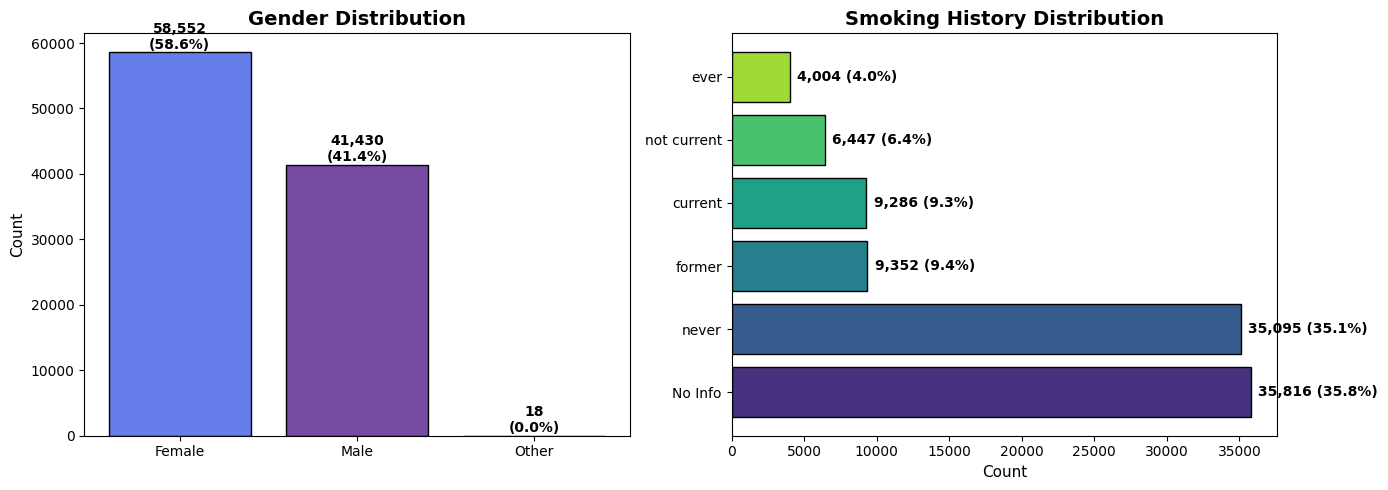

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Gender Distribution
gender_counts = df['gender'].value_counts()
axes[0].bar(gender_counts.index, gender_counts.values, color=['#667eea', '#764ba2', '#f093fb'], edgecolor='black')
axes[0].set_title('Gender Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11)
for i, v in enumerate(gender_counts.values):
    axes[0].text(i, v + 500, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')



# Smoking History Distribution
smoking_counts = df['smoking_history'].value_counts()
axes[1].barh(smoking_counts.index, smoking_counts.values, color=sns.color_palette('viridis', len(smoking_counts)), edgecolor='black')
axes[1].set_title('Smoking History Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Count', fontsize=11)
for i, v in enumerate(smoking_counts.values):
    axes[1].text(v + 500, i, f'{v:,} ({v/len(df)*100:.1f}%)', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

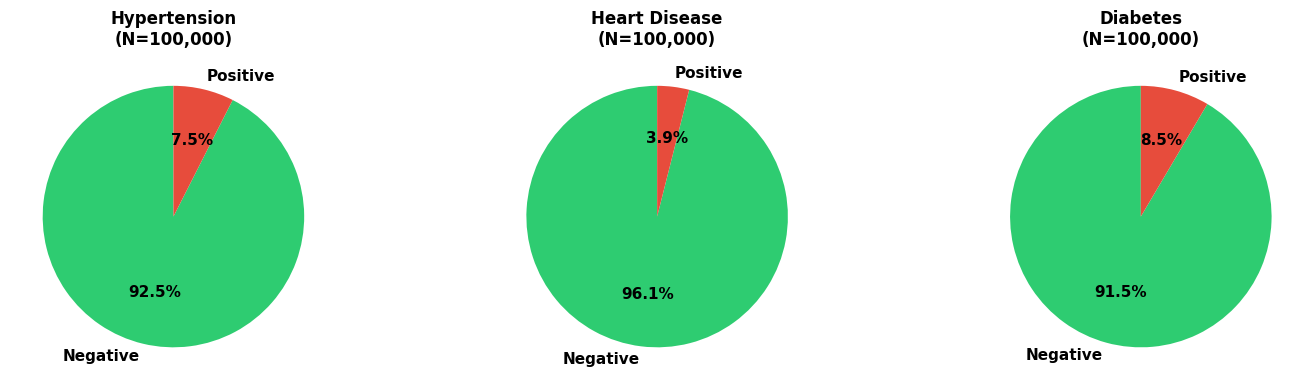

 Binary Feature Statistics:

hypertension         | Positive:  7,485 ( 7.49%) | Negative: 92,515 (92.52%)
heart_disease        | Positive:  3,942 ( 3.94%) | Negative: 96,058 (96.06%)
diabetes             | Positive:  8,500 ( 8.50%) | Negative: 91,500 (91.50%)


In [ ]:
binary_features = ['hypertension', 'heart_disease', 'diabetes']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, feature in enumerate(binary_features):
    counts = df[feature].value_counts()
    colors = ['#2ecc71', '#e74c3c']

    axes[idx].pie(counts, labels=['Negative', 'Positive'], autopct='%1.1f%%',
                  colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    axes[idx].set_title(f'{feature.replace("_", " ").title()}\n(N={len(df):,})',
                        fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print(" Binary Feature Statistics:\n")

for feature in binary_features:
    positive = df[feature].sum()
    total = len(df)
    print(f"{feature:20s} | Positive: {positive:6,} ({positive/total*100:5.2f}%) | Negative: {total-positive:6,} ({(total-positive)/total*100:5.2f}%)")

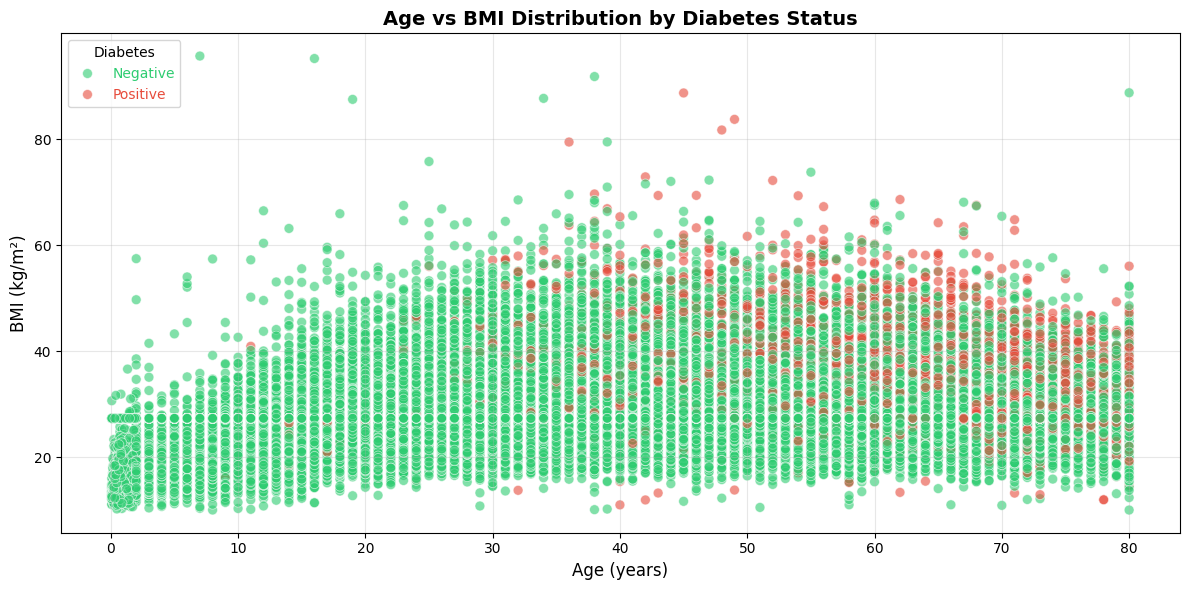

In [ ]:
#Bivariate Analysis : Age and BMI vs Target Variable
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=df, x='age', y='bmi', hue='diabetes',
                palette={0: '#2ecc71', 1: '#e74c3c'}, alpha=0.6, s=50)
plt.title('Age vs BMI Distribution by Diabetes Status', fontsize=14, fontweight='bold')
plt.xlabel('Age (years)', fontsize=12)
plt.ylabel('BMI (kg/m²)', fontsize=12)

legend = ax.get_legend()

if legend:
    for i, text in enumerate(legend.get_texts()):
        if i == 0: # Corresponds to diabetes=0 (Negative)
            text.set_text('Negative')
            text.set_color('#2ecc71')
        elif i == 1: # Corresponds to diabetes=1 (Positive)
            text.set_text('Positive')
            text.set_color('#e74c3c')
    legend.set_title('Diabetes') # Set the legend title

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2343446415.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2343446415.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2343446415.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2343446415.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


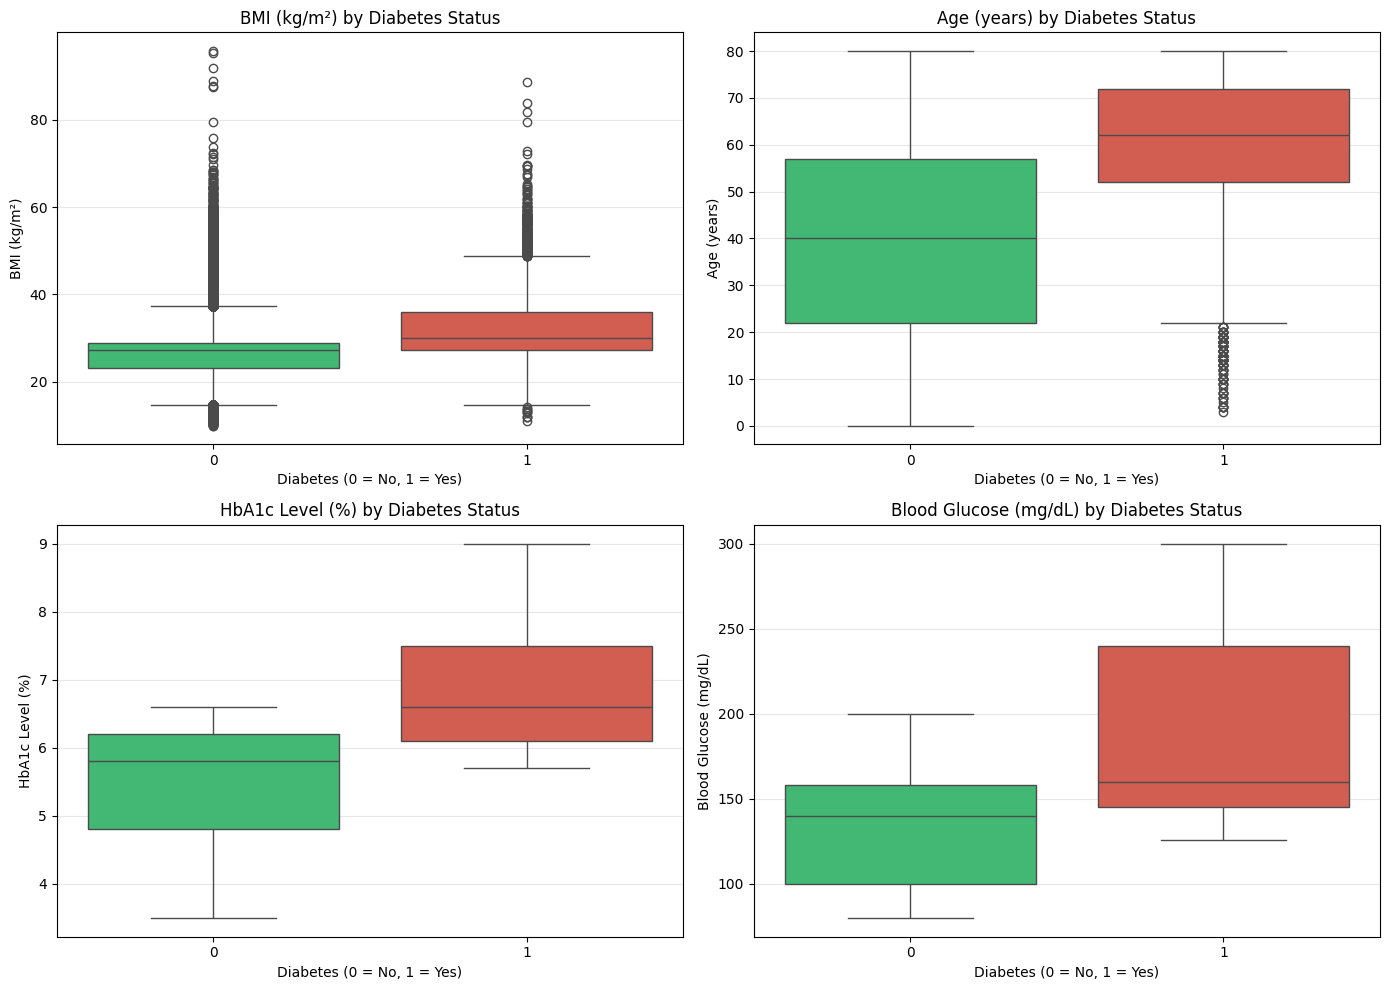

In [ ]:
#Clincal Markers by Diabetes Status

df['diabetes'] = df['diabetes'].astype('category')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
features = ['bmi','age','HbA1c_level','blood_glucose_level']
titles = ['BMI (kg/m²)', 'Age (years)', 'HbA1c Level (%)', 'Blood Glucose (mg/dL)']

for idx in range(len(features)):
  ax = axes[idx//2,idx%2]

  sns.boxplot(
      data = df,
      x = 'diabetes',
      palette=['#2ecc71', '#e74c3c'],
      y = features[idx],
      ax = ax
  )
  ax.set_title(f'{titles[idx]} by Diabetes Status')
  ax.set_xlabel('Diabetes (0 = No, 1 = Yes)')
  ax.set_ylabel(titles[idx])
  ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#level 3 : Data Preprocessing and Feature Engineering

#3.1 Categorical Encoding
#one hot encode categorical variable

df_encoded = pd.get_dummies(df,columns=['gender','smoking_history'],drop_first=False)

df_encoded



,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,True,False,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,True,False,False,True,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,False,True,False,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,True,False,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0,True,False,False,True,False,False,False,False,False
99996,2.0,0,0,17.37,6.5,100,0,True,False,False,True,False,False,False,False,False
99997,66.0,0,0,27.83,5.7,155,0,False,True,False,False,False,False,True,False,False
99998,24.0,0,0,35.42,4.0,100,0,True,False,False,False,False,False,False,True,False


In [ ]:
#step 3.2 Train Test Split

df_encoded.dropna(subset=['diabetes'],inplace=True)

X = df_encoded.drop('diabetes',axis=1)
y = df_encoded['diabetes']

X.shape,y.shape

((100000, 15), (100000,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features:     {X_train.shape[1]}")

Training set: 80,000 samples (80.0%)
Test set:     20,000 samples (20.0%)
Features:     15


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train model and compute comprehensive metrics"""

    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    return {
        'Model': model_name,
        'Test Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'CV Mean': cv_mean,
        'CV Std': cv_std,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }

In [ ]:
models_config = {
    'Logistic Regression': LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=200, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42,
                             use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=-1, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=300, learning_rate=0.05, depth=8, random_state=42, verbose=0)
}

In [ ]:
results = []
predictions_dict = {}

for name, model in models_config.items():
    print(f"Training {name}...", end=" ")
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)
    predictions_dict[name] = result['Predictions']
    print(f"Accuracy: {result['Test Accuracy']:.4f} | F1: {result['F1 Score']:.4f} | ROC-AUC: {result['ROC AUC']:.4f}")

Training Logistic Regression... Accuracy: 0.9600 | F1: 0.7294 | ROC-AUC: 0.9625
Training Random Forest... Accuracy: 0.9700 | F1: 0.7966 | ROC-AUC: 0.9605
Training XGBoost... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:32:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:32:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:32:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:32:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:32:12] WARNING: /w

Accuracy: 0.9723 | F1: 0.8091 | ROC-AUC: 0.9799
Training LightGBM... Accuracy: 0.9716 | F1: 0.8049 | ROC-AUC: 0.9791
Training CatBoost... Accuracy: 0.9718 | F1: 0.8067 | ROC-AUC: 0.9794


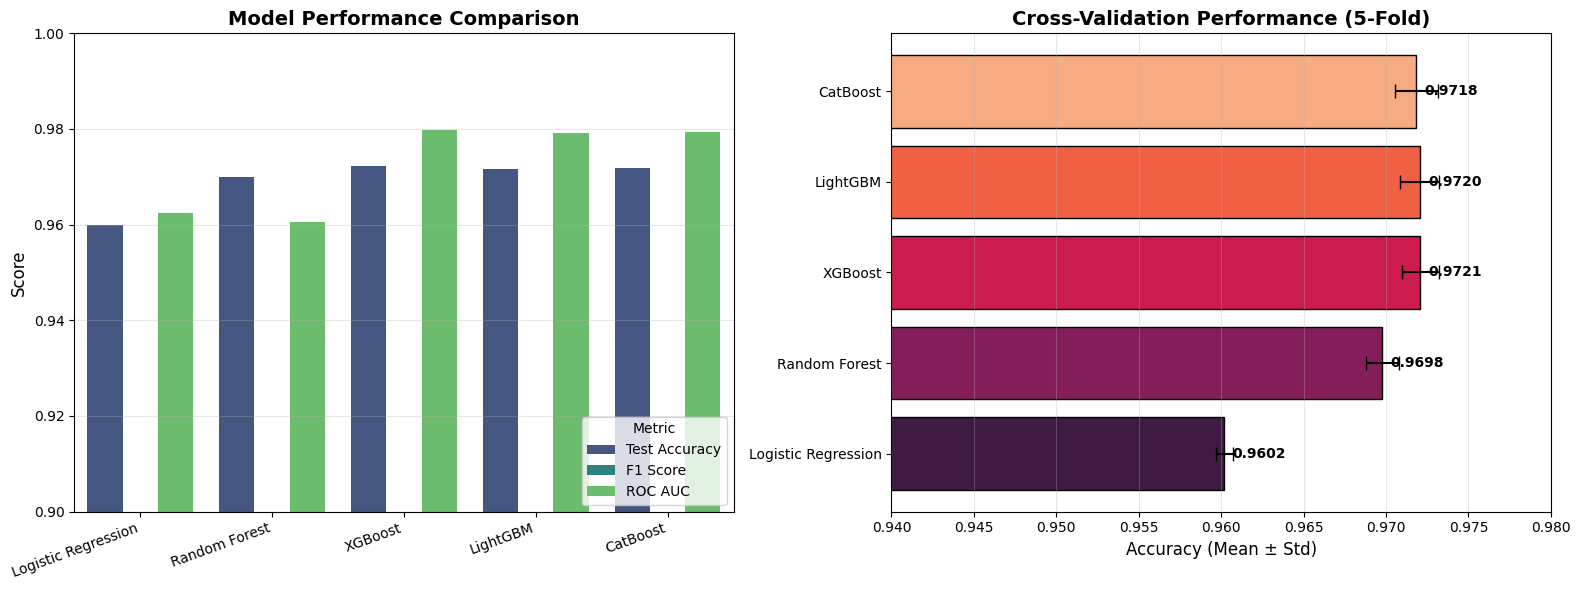

In [ ]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics_to_plot = ['Test Accuracy', 'F1 Score', 'ROC AUC']
results_melted = results_df.melt(id_vars=['Model'], value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', ax=axes[0], palette='viridis')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim(0.90, 1.0)
axes[0].legend(title='Metric', loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=20, ha='right')

# Cross-validation scores
cv_data = results_df[['Model', 'CV Mean', 'CV Std']]
axes[1].barh(cv_data['Model'], cv_data['CV Mean'], xerr=cv_data['CV Std'],
             color=sns.color_palette('rocket', len(cv_data)), edgecolor='black', capsize=5)
axes[1].set_title('Cross-Validation Performance (5-Fold)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Accuracy (Mean ± Std)', fontsize=12)
axes[1].set_xlim(0.94, 0.98)
axes[1].grid(axis='x', alpha=0.3)

for i, row in cv_data.iterrows():
    axes[1].text(row['CV Mean'] + 0.0005, i, f"{row['CV Mean']:.4f}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

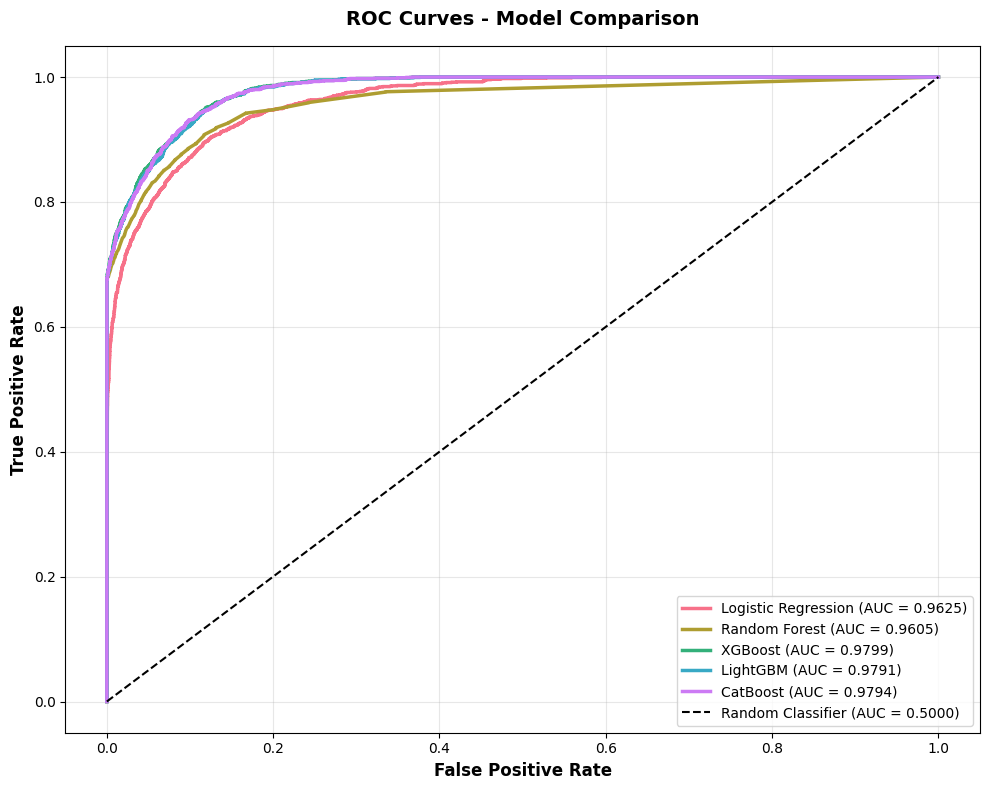

In [ ]:
plt.figure(figsize=(10, 8))

colors = sns.color_palette('husl', len(models_config))

for idx, result in enumerate(results):
    if result['Probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['Probabilities'])
        auc = result['ROC AUC']
        plt.plot(fpr, tpr, label=f"{result['Model']} (AUC = {auc:.4f})",
                 linewidth=2.5, color=colors[idx])

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier (AUC = 0.5000)')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()